## Packages required

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import LogisticRegression as lr
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import Lasso as ls 

from sklearn.metrics import roc_auc_score 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, GradientBoostingRegressor

In [64]:
als =  pd.read_csv("../Assignment3/ALS.txt", delimiter = " ")
als.tail()

,testset,dFRS,Onset.Delta,Symptom.Speech,Symptom.WEAKNESS,Symptom.OTHER,Symptom.Swallowing,Symptom.GAIT_CHANGES,Symptom.Atrophy,Symptom.Cramps,...,max.slope.bp.systolic,min.slope.bp.systolic,last.slope.bp.systolic,mean.slope.bp.systolic,num.slope.bp.systolic.visits,sum.slope.bp.systolic,first.slope.bp.systolic.date,meansquares.slope.bp.systolic,sd.slope.bp.systolic,slope.bp.systolic.slope
1817,False,-1.104556,-816,0,1,0,0,0,0,0,...,38.737576,-10.870238,8.696190,6.902892,4,27.611567,5.5,443.630796,19.899268,-13.446465
1818,False,-0.434810,-288,0,0,0,0,0,0,0,...,8.951961,-40.582222,0.000000,-10.543420,3,-31.630261,7.5,575.684787,21.552751,18.574249
1819,False,-0.281821,-817,0,1,0,0,0,0,0,...,0.000000,-19.566429,0.000000,-9.783214,2,-19.566429,35.0,191.422564,9.783214,18.046572
1820,False,0.000000,-1589,0,1,0,0,0,0,0,...,26.088571,-15.781975,12.594483,4.275905,4,17.103619,10.5,280.478961,16.192455,6.997368
1821,False,-2.051910,-204,1,1,0,0,0,0,0,...,21.740476,-26.088571,9.818280,1.823395,3,5.470184,7.0,416.553493,20.328028,-6.310816


In [65]:
# choose all regressors except dFRS and testid
x3 = als.drop(["testset","dFRS"], axis=1)
y3 = als.dFRS

In [66]:
# Select a subset of the DataFrame
subset_df = als.sample(frac=0.8, random_state=42)

# Split the data into training and validation sets
x3_train, x3_valid, y3_train, y3_valid = train_test_split(x3, y3, test_size=0.2, random_state=0)

In [67]:
# set the depth, no of trees, and the shrinkage values
d = 3
n_trees = 250
shrinkage_params = [0.02, 0.5]

train_errors = []
val_errors = []

In [68]:
for s in shrinkage_params:
    model = GradientBoostingRegressor(n_estimators = 250, learning_rate=s, max_depth=d, random_state=0)

    # Fit model to the training data
    model.fit(x3_train, y3_train)

    train_error = np.zeros((n_trees,), dtype=np.float64)
    
    for i, y_pred in enumerate(model.staged_predict(x3_train)):
        train_error[i] = model.loss_(y3_train, y_pred)

    # validation error
    val_error = np.zeros((n_trees,), dtype=np.float64)
    for i, y_pred in enumerate(model.staged_predict(x3_valid)):
        val_error[i] = model.loss_(y3_valid, y_pred)

    # Append errors to the lists
    train_errors.append(train_error)
    val_errors.append(val_error)

C:\Users\Jack\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Jack\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Jack\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Jack\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


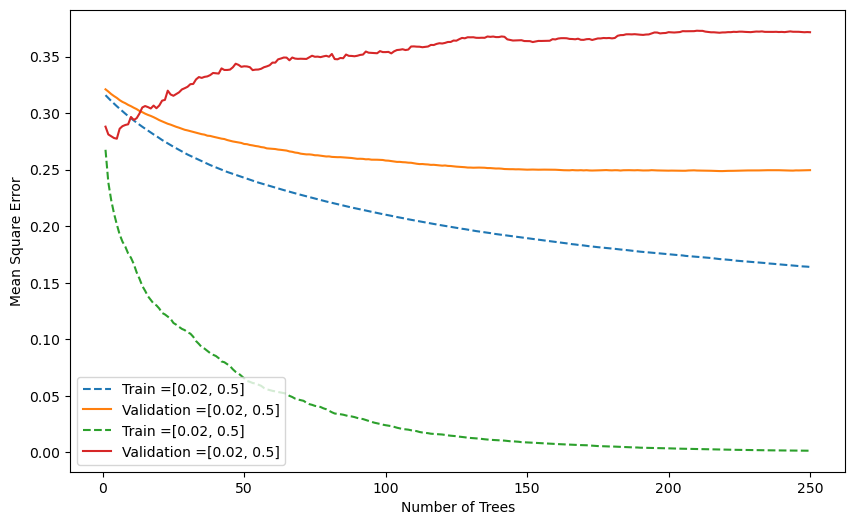

In [69]:
plt.figure(figsize=(10, 6))

for i, s in enumerate(shrinkage_params):
    plt.plot(np.arange(1, n_trees + 1), train_errors[i], linestyle='dashed', label=f'Train ={shrinkage_params}')
    plt.plot(np.arange(1, n_trees + 1), val_errors[i], label=f'Validation ={shrinkage_params}')

plt.xlabel('Number of Trees')
plt.ylabel('Mean Square Error')
plt.legend(loc = 'lower left')
plt.show()

### Based on the plot above:

- With ε = 0.5, the training error drops rapidly with the number of trees, but the validation error starts to increase rapidly after an initial decrease.
  
- With ε = 0.02, the training error drops more slowly while the validation error also drops more slowly, but reaches a lower minimum.

- ε is a tuning parameter because it acts as a scales for the contribution of each tree's predictions by a factor of ε. It is important as it is affects how much each tree corrects the errors of the previous trees.

## Problem 3(b)

In [70]:
# Define the range of number of trees (400 instead of 2500 in the textbook)
n_trees = np.arange(1, 500, 100)  

# Initialize lists
boosting_errors = []
rf_errors = []
bagging_errors = []

In [71]:
for n in n_trees:
    
    # Gradient Boosting
    boosting = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, random_state=42)
    boosting.fit(x2_train, y2_train)
    boosting_predictions = boosting.predict(x2_test)
    boosting_error = 1 - accuracy_score(y2_test, boosting_predictions)
    boosting_errors.append(boosting_error)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(x2_train, y2_train)
    rf_predictions = rf.predict(x2_test)
    rf_error = 1 - accuracy_score(y2_test, rf_predictions)
    rf_errors.append(rf_error)

    # Bagging
    bagging = BaggingClassifier(n_estimators=n, random_state=42)
    bagging.fit(x2_train, y2_train)
    bagging_predictions = bagging.predict(x2_test)
    bagging_error = 1 - accuracy_score(y2_test, bagging_predictions)
    bagging_errors.append(bagging_error)

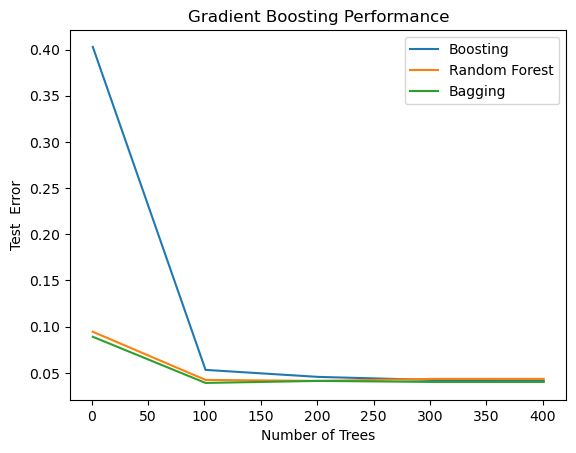

In [72]:
# Plot the results
plt.plot(n_trees, boosting_errors, label='Boosting')
plt.plot(n_trees, rf_errors, label='Random Forest')
plt.plot(n_trees, bagging_errors, label='Bagging')

plt.xlabel('Number of Trees')
plt.ylabel('Test  Error')
plt.title('Gradient Boosting Performance')
plt.legend(loc = 'upper right')
plt.show()


## Problem 3(c)

In [73]:
# Initialize lists to store misclassification errors
bagging_oob_errors = []
rf_oob_errors = []

# Loop through the number of trees
for n in n_trees:
    # Random Forest with OOB estimation
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rf.fit(x2_train, y2_train)
    rf_oob_error = 1 - rf.oob_score_
    rf_oob_errors.append(rf_oob_error)

    # Bagging with OOB estimation
    bagging = BaggingClassifier(n_estimators=n, oob_score=True, random_state=42)
    bagging.fit(x2_train, y2_train)
    bagging_oob_error = 1 - bagging.oob_score_
    bagging_oob_errors.append(bagging_oob_error)


C:\Users\Jack\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Jack\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\Jack\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


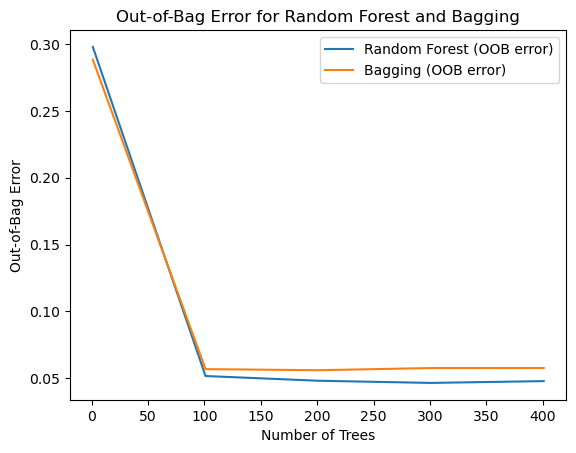

In [74]:
# Plot
plt.plot(n_trees, rf_oob_errors, label='Random Forest (OOB error)')
plt.plot(n_trees, bagging_oob_errors, label='Bagging (OOB error)')

plt.xlabel('Number of Trees')
plt.ylabel('Out-of-Bag Error')
plt.title('Out-of-Bag Error for Random Forest and Bagging')
plt.legend(loc='upper right')
plt.show()